# Продолжение
Основная идея данной части проекта - модификация полученной модели для расширенной классификации 

(добавили класс Other: текст не принадлежит ни одному из описанных в прошлой части проекта классов).


## Новое начало
Подключим необходимые библиотеки, обьявим необходимые функции и константы.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
import sys, os
sys.path.append('/Users/nikitos_paravoz/Desktop/DL/NLPClassification/')
sys.path.append('/Users/nikitos_paravoz/Desktop/DL/NLPClassification/mylib/')
import mylib.ecommercedata as edata
import mylib.mymodel as mymodel
from mylib.ecommercedata import text_preprocess
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [2]:
DEVICE = mymodel.DEVICE
BATCH_SIZE = 32

## Новый класс, новые методы
Постараемся сравнить два подхода для моделирования нового класса: аналитический и практический

In [3]:
category_dict = {'Household': 0, 'Books': 1, 'Clothing & Accessories': 2, 'Electronics' : 3}
other_category_dict = {'Household' : 0, 'Books' : 1, 'Clothing & Accessories' : 2, 'Electronics' : 3, 'Other' : 4}
data, _ = edata.prepare_data('ecommerceDataset.csv', category_dict)
save_y = data['category']
_, save_test_indices = edata.train_test_indices(data)
newdata, seq_len = edata.prepare_data('otherDataset.csv', other_category_dict)
train_indices, test_indices = edata.train_test_indices(newdata)

### Практический подход:
Постараемся научить нашу модель распознавать текст на 5 классов, отдавая возможность распределять веса для этого самой по себе.


Новый класс - описание товаров из иных классов.

In [110]:
X = newdata['description']
y = newdata['category']
vocabulary, vocabulary_to_int = edata.build_vocab(X)
X_tok = edata.huge_tokenize(X, vocabulary_to_int).to(int)

In [109]:
import gensim
modelfsttxt = gensim.models.KeyedVectors.load_word2vec_format('crawl-300d-2M.vec')
embedding_dict = modelfsttxt.key_to_index

In [111]:
VOCAB_SIZE = len(vocabulary) + 1
EMBEDDING_DIM = 300
HIDDEN_DIM = 100
NUM_CLASSES = 5
LSTM_LAYERS = 1
IS_BIDIRECTIONAL = True
LR = 1e-4

In [112]:
def prepare_matrix(embedding_dict):
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    for word, token in vocabulary:
        if word in embedding_dict:
            embedding_vector = modelfsttxt[word]
            embedding_matrix[token] = embedding_vector
    return embedding_matrix

In [113]:
model = mymodel.LSTM_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, IS_BIDIRECTIONAL)
model.to(DEVICE)
embedding_matrix = prepare_matrix(embedding_dict)
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Создадим датасеты для расширенной класификации, а также сохраним тестовую выборку из предыдущего пункта, для проверки того, что модель не нарушила своей изначальной идеи - классификации товаров на 4 категории.

In [114]:
X_train = [X_tok[idx] for idx in train_indices]
y_train = [y[idx] for idx in train_indices]
X_test = [X_tok[idx] for idx in test_indices]
y_test = [y[idx] for idx in test_indices]
save_X_test = [X_tok[idx] for idx in save_test_indices]
save_y_test = [save_y[idx] for idx in save_test_indices]
train_dataset = edata.EcommerceDataset(X_train, y_train)
test_dataset = edata.EcommerceDataset(X_test, y_test)
save_test_dataset = edata.EcommerceDataset(save_X_test, save_y_test)
trainval_size = len(train_dataset)
val_size = int(trainval_size * 0.15)
train_size = trainval_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
save_test_loader = DataLoader(save_test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [115]:
#model = mymodel.train(model, train_loader, valid_loader, DEVICE, criterion, optimizer)
model = mymodel.LSTM_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, IS_BIDIRECTIONAL)
model.to(DEVICE)
model.load_state_dict(torch.load('new_model.pt'))
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
def make_some_metrics(test_accuracy, test_loss, y_true, y_pred, category_list, modelname):
    print(f'Testing finished for {modelname}: Accuracy =  {test_accuracy}%, Loss = {test_loss} \nClassification report:\n', classification_report(y_true, y_pred, target_names=category_list, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=category_list)
    cm_display.plot(cmap="BuPu", xticks_rotation=45)

Протестируем модель на новом датасете:

Testing finished for model on new dataset: Accuracy =  95.95%, Loss = 0.15571591976005092 
Classification report:
                         precision    recall  f1-score   support

             Household     0.9729    0.9645    0.9687      1971
                 Books     0.9306    0.9798    0.9546      1040
Clothing & Accessories     0.9827    0.9623    0.9724      1060
           Electronics     0.9489    0.9566    0.9527       990
                 Other     0.9512    0.9281    0.9395       987

              accuracy                         0.9595      6048
             macro avg     0.9572    0.9582    0.9576      6048
          weighted avg     0.9599    0.9595    0.9595      6048



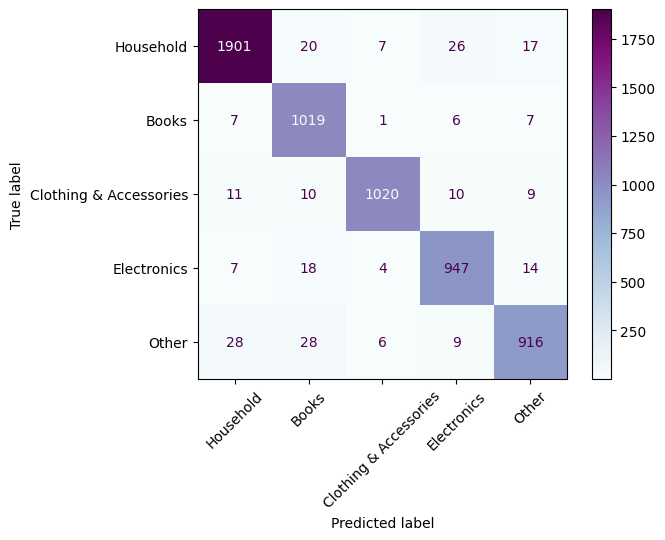

In [116]:
test_accuracy, test_loss, y_pred_list, y_test_list = mymodel.test(model, DEVICE, test_loader, criterion)
make_some_metrics(test_accuracy, test_loss, y_pred_list, y_test_list, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'model on new dataset')

Протестируем модель на сохранненой выборке:

Testing finished for model on saved dataset: Accuracy =  94.27%, Loss = 0.2801054874377221 
Classification report:
                         precision    recall  f1-score   support

             Household     0.9682    0.9701    0.9691      1975
                 Books     0.9176    0.9715    0.9438      1089
Clothing & Accessories     0.9572    0.9498    0.9535      1036
           Electronics     0.9062    0.9404    0.9230       956
                 Other     0.0000    0.0000    0.0000        96

              accuracy                         0.9427      5152
             macro avg     0.7498    0.7664    0.7579      5152
          weighted avg     0.9257    0.9427    0.9340      5152



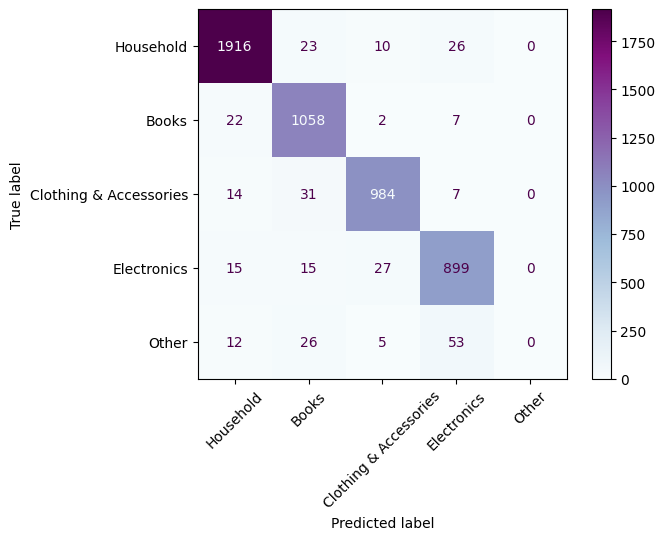

In [117]:
save_test_accuracy, save_test_loss, save_y_pred_list, save_y_test_list = mymodel.test(model, DEVICE, save_test_loader, criterion)
make_some_metrics(save_test_accuracy, save_test_loss, save_y_pred_list, save_y_test_list, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'model on saved dataset')

### Итог практического подхода:
Как видно, модель с хорошей точностью определяет класс Other, при этом не теряя в точности предсказаний на предыдущие классы.
Результат удовлетворяет требованиям, но стоит рассмотреть и аналитический подход, речь о котором пойдет ниже.

### Аналитический подход:

С помощью диаграммы размаха (boxplot, ящик с усами), найдем нижнюю границу уверенности в выбранном классе модели из предыдущего пункта. С помощью этой нижней границы создадим threshold метод для новой классификации.

In [125]:
prevX = data['description']
prevvocabulary, prevvocabulary_to_int = edata.build_vocab(prevX)
prev_X_tok = edata.huge_tokenize(prevX, prevvocabulary_to_int).to(int)
prev_X_test = [prev_X_tok[idx] for idx in save_test_indices]
prev_y_test = [save_y[idx] for idx in save_test_indices]

In [164]:
X_tok_new = edata.huge_tokenize(X, prevvocabulary_to_int).to(int)
X_test_new = [X_tok_new[idx] for idx in test_indices]
y_test_new = [y[idx] for idx in test_indices]

In [165]:
new_test_dataset =  edata.EcommerceDataset(X_test_new, y_test_new )
new_test_loader = DataLoader(new_test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [126]:
prev_test_dataset = edata.EcommerceDataset(prev_X_test, prev_y_test)
prev_test_loader = DataLoader(prev_test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [167]:
prevmodel = mymodel.LSTM_Classifier(len(prevvocabulary) + 1, 300, 100, 4, 1, True)
prevmodel.load_state_dict(torch.load('saved_model.pt'))
prevmodel.to(DEVICE)

LSTM_Classifier(
  (embedding): Embedding(48806, 300, padding_idx=0)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=200, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)

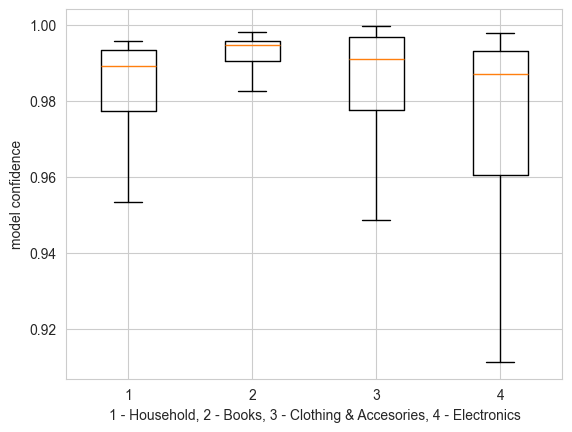

In [151]:
'''
category = ['Household', 'Books', 'Clothing & Accesories', 'Electronics']
rows_list = []
from tqdm import tqdm
with torch.no_grad():
    for x in tqdm(X_test):
        x, h = x.reshape(1, len(x)).to(DEVICE),  model.init_hidden(1)
        out, _, _ = model(x, h)
        pred = torch.argmax(out, dim=1).to(int)
        prob = torch.exp(out).to(torch.float32).squeeze()
        dictrow = {category[pred] : float(prob[pred])}
        rows_list.append(dictrow)
df = pd.DataFrame(rows_list, columns=category)
df_h = df['Household']
df_b = df['Books']
df_c = df['Clothing & Accesories']
df_e = df['Electronics']
...
plt.boxplot([df_h, df_b, df_c, df_e], 0, '')
...
'''
from IPython.display import Image
Image(filename='boxplot.png')

Рассмотрим precision и recall, для модели из предыдущего пункта с разными значениями параметра threshold`а.

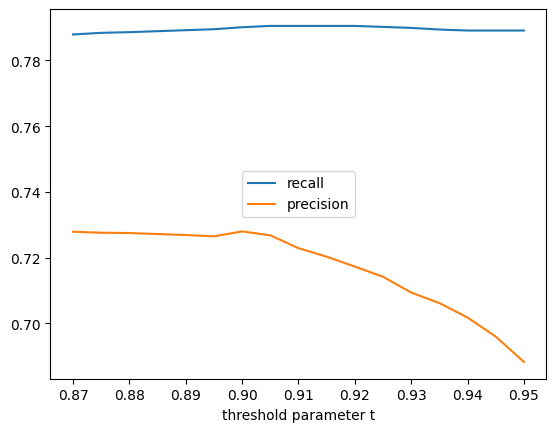

In [152]:
x_t = [0.87, 0.875, 0.88, 0.885, 0.89, 0.895, 0.9, 0.905,
       0.91, 0.915, 0.92, 0.925, 0.93, 0.935, 0.94, 0.945, 0.95]

y_precision_recall_macroavg = [[0.7279, 0.7879], [0.7276, 0.7884], [0.7275, 0.7886], [0.7272, 0.7889], [0.7269, 0.7892], [0.7265, 0.7895], [0.7280, 0.7901], [0.7268, 0.7905], [
    0.7229, 0.7905], [0.7203, 0.7905], [0.7173, 0.7905], [0.7142, 0.7902], [0.7094, 0.7899], [0.7062, 0.7894], [0.7018, 0.7891], [0.6960, 0.7891], [0.6883, 0.7891]]
y_prec_mavg = [_[0] for _ in y_precision_recall_macroavg]
y_recl_mavg = [_[1] for _ in y_precision_recall_macroavg]

line1, = plt.plot(x_t, y_recl_mavg, label="recall")
line2, = plt.plot(x_t, y_prec_mavg, label="precision")
leg = plt.legend(loc='center')
plt.xlabel('threshold parameter t')
plt.show()

Как видно из диаграммы, пороговое значение t ~ 0.9 будет достаточно точно отделять исходные классы от добавленного.

In [157]:
def threshold_test(model, device, dataloader, loss_fn, t=0.9):
    losses  = []
    y_pred_list = []
    y_test_list = []
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            h = model.init_hidden(y_batch.size(0))
            output, h, attn = model(x_batch, h)
            
            loss = loss_fn(output, y_batch)
            losses.append(loss.item())

            y_pred = torch.argmax(output, dim=1)
            
            y_check, _ = torch.max(torch.exp(output), dim=1)
            y_pred += 1
            mask = y_check > t
            y_pred *= mask
            y_pred -= 1
            
            y_pred = torch.Tensor(list(map(lambda x: 4 if x == -1 else x, y_pred))).to(int).to(DEVICE)
            
            correct += torch.sum(y_pred==y_batch).item()
            total += y_batch.size(0)
            y_pred_list.extend(y_pred.squeeze().tolist())
            y_test_list.extend(y_batch.squeeze().tolist())

    accuracy = round(100 * correct / total, 2)
    return accuracy, np.mean(losses), y_pred_list, y_test_list

Testing finished for previous model on previous dataset with threshold: Accuracy =  91.32%, Loss = 0.13268931951049878 
Classification report:
                         precision    recall  f1-score   support

             Household     0.9242    0.9839    0.9531      1859
                 Books     0.9211    0.9925    0.9555      1070
Clothing & Accessories     0.9300    0.9866    0.9574       969
           Electronics     0.8649    0.9873    0.9221       869
                 Other     0.0000    0.0000    0.0000       385

              accuracy                         0.9132      5152
             macro avg     0.7280    0.7901    0.7576      5152
          weighted avg     0.8456    0.9132    0.8780      5152



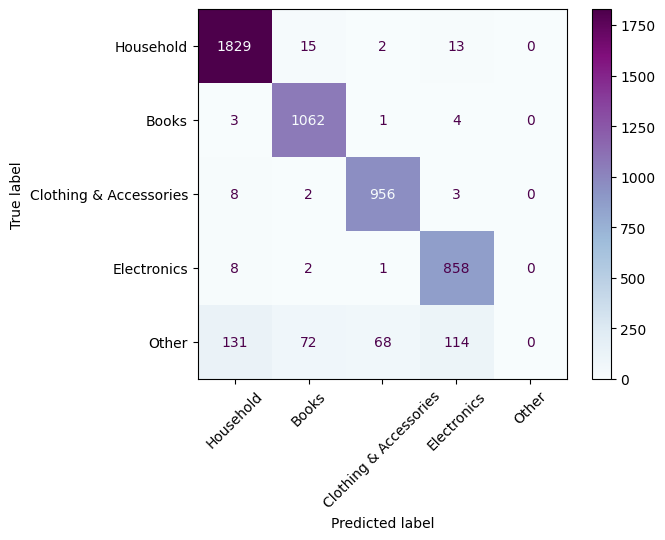

In [174]:
prev_test_acc, prev_test_loss, prev_y_predl, prev_y_testl = threshold_test(prevmodel, DEVICE, prev_test_loader, criterion)
make_some_metrics(prev_test_acc, prev_test_loss, prev_y_predl, prev_y_testl, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'previous model on previous dataset with threshold')

Testing finished for previous model on new dataset with threshold: Accuracy =  87.6%, Loss = 0.12072849857113349 
Classification report:
                         precision    recall  f1-score   support

             Household     0.9243    0.9436    0.9338      1914
                 Books     0.9123    0.9008    0.9065      1109
Clothing & Accessories     0.9297    0.8993    0.9143      1073
           Electronics     0.8567    0.9628    0.9067       888
                 Other     0.6989    0.6325    0.6640      1064

              accuracy                         0.8760      6048
             macro avg     0.8644    0.8678    0.8651      6048
          weighted avg     0.8735    0.8760    0.8739      6048



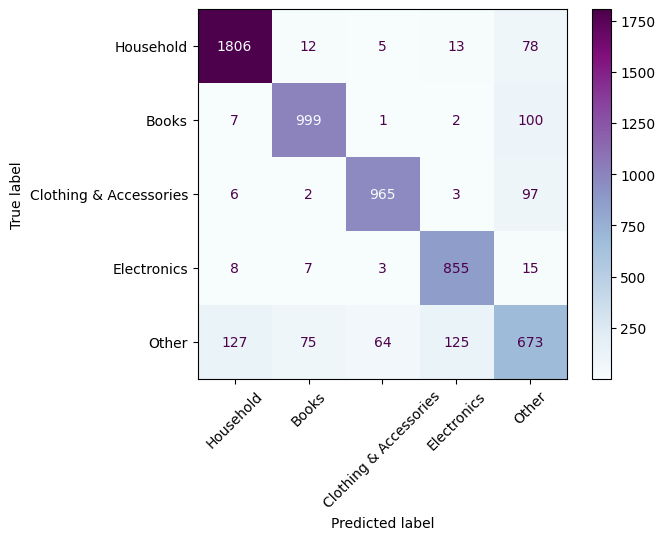

In [175]:
prev_test_acc, prev_test_loss, prev_y_predl, prev_y_testl = threshold_test(prevmodel, DEVICE, new_test_loader, criterion)
make_some_metrics(prev_test_acc, prev_test_loss, prev_y_predl, prev_y_testl, ['Household', 'Books', 'Clothing & Accessories', 'Electronics', 'Other'], 'previous model on new dataset with threshold')

### Итог аналитического подхода
Протестированное пороговое значение на расширенном датасете выдает результаты хуже, чем модель, обученная на определение 5-го класса. 